In [1]:
%%capture 
# Set up a virtual environment and install necessary libraries
!python3 -m venv venv # Create a new virtual environment named 'venv'
!source venv/bin/activate # Activate the virtual environment
!pip install tensorflow transformers # Install TensorFlow and Hugging Face transformers in the venv

!pip install imbalanced-learn # Install the imbalanced-learn library, which provides tools for handling imbalanced datasets

In [2]:
# Import necessary libraries and modules for data processing, machine learning, and NLP tasks
import pandas as pd # Data manipulation and analysis
import tensorflow as tf # Deep learning library
from transformers import TFDistilBertModel, DistilBertTokenizer, TFDistilBertForSequenceClassification # Pre-trained models from Hugging Face Transformers library
import pickle # Serializing and de-serializing Python object structures

from sklearn.metrics import classification_report, confusion_matrix # For model evaluation metrics
import seaborn as sns # Visualization library, especially for heatmaps
import matplotlib.pyplot as plt # Plotting library

from sklearn.utils.class_weight import compute_class_weight # Utility to compute class weights
import numpy as np # Numerical operations on arrays

from tensorflow.keras.layers import Dropout, Input, Dense, Lambda # Keras layers for building the model
from tensorflow.keras.models import Model # Keras Model API for defining and training the model

import os # Operating system utilities

from imblearn.over_sampling import SMOTE # SMOTE for oversampling to handle class imbalance
from sklearn.model_selection import train_test_split # Utility for splitting data into training and test sets

from transformers import logging # Transformer logging utilities

import warnings # Suppresses various warnings

brief summary of each imported module or function:
* **pandas, numpy**: Used for handling and processing data in structured formats.
* **tensorflow, transformers**: For building and running the DistilBERT model.
* **classification_report, confusion_matrix**: For evaluating model predictions.
* **seaborn, matplotlib.pyplot**: For data visualization, particularly confusion matrices.
* **compute_class_weight, SMOTE**: For managing class imbalance in the dataset.
* **train_test_split**: For splitting the dataset into training and test sets.
* **warnings, logging**: To manage warnings and logging, respectively.

In [3]:
# Load the dataset from a CSV file
df = pd.read_csv("/kaggle/input/fake-news-classification/WELFake_Dataset.csv")
# Display the first few rows of the dataset to understand its structure
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
# Check the distribution of labels (e.g., how many instances are fake vs. real news)
df['label'].value_counts()

label
1    37106
0    35028
Name: count, dtype: int64

In [5]:
# Extract the text and labels into separate lists for easy processing
x = list(df['text']) # 'x' will hold the text data
y = list(df['label']) # 'y' will hold the corresponding labels (e.g., fake or real)

In [6]:
# Suppress future warnings from appearing in the output
warnings.filterwarnings("ignore", category=FutureWarning)
# Set up the model and tokenizer parameters
MODEL_NAME = 'distilbert-base-uncased' # Use the pre-trained 'distilbert-base-uncased' model from Hugging Face
MAX_LEN = 100 # Maximum token length for each input sequence; sequences longer than this will be truncated

# For illustration, we'll process the first review in the dataset
review = x[0]

# Initialize the tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
# Tokenize the sample review with specified max length and padding
inputs = tokenizer(review, max_length=MAX_LEN, truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

* **Warning Suppression**: warnings.filterwarnings is used to suppress future warnings from TensorFlow and other libraries.
* **Model and Tokenizer Setup**: We specify MODEL_NAME as distilbert-base-uncased, and MAX_LEN limits each tokenized sequence to 100 tokens.
* **Tokenization**: The tokenizer converts the review into input IDs and attention masks. truncation=True ensures longer texts are cut to MAX_LEN, and padding=True adds padding to make all sequences of uniform length.

# Define Model

In [7]:
# Define a helper function for encoding inputs using the DistilBERT tokenizer
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    # Tokenize the input list `x` with specified maximum length, truncation, and padding
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)

* **Helper Function (construct_encodings)**: This function uses the tokenizer to encode a list of texts (x) with the specified max_len, truncation, and padding options, making it reusable for different parts of the pipeline.

In [8]:
# Convert all items in `x` to strings to ensure compatibility with the tokenizer
x = [str(item) for item in x]

# Encode the input texts (`x`) using the specified tokenizer and maximum length
encodings = construct_encodings(x, tokenizer, max_len=MAX_LEN)
# Set up constants for data split and batch processing
TEST_SPLIT = 0.3 # Define the proportion of data to be used for testing
BATCH_SIZE = 8 # Define the batch size for training and evaluation

# Separate the encoded results into input IDs and attention masks
input_ids = encodings['input_ids'] # Tokenized IDs for each word in the texts
attention_masks = encodings['attention_mask'] # Masks indicating real tokens (1) vs padding (0)

# Split the data into training and testing sets (both input data and attention masks)
x_train, x_test, y_train, y_test, masks_train, masks_test = train_test_split(
    input_ids,            # Tokenized text input IDs for training/testing
    y,                    # Corresponding labels for training/testing
    attention_masks,      # Attention masks for training/testing
    test_size=TEST_SPLIT, # Ratio for test data
    random_state=42,      # Seed for reproducibility
    stratify=y            # Maintain label distribution in train and test splits
)

# Initialize SMOTE (Synthetic Minority Over-sampling Technique) for handling class imbalance in training data
smote = SMOTE(random_state=42)
# Apply SMOTE only on the training data (input IDs and labels) to create synthetic samples for the minority class
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Adjust attention masks for the new samples generated by SMOTE
# Note: SMOTE only generates synthetic samples for input features. We use `np.repeat` to match the number of masks
masks_train_resampled = np.repeat(
    masks_train, # Original masks for training
    np.ceil(len(x_train_resampled) / len(masks_train)).astype(int), # Repeat factor to match new length
    axis=0 # Repeat along the rows
)[:len(x_train_resampled)] # Trim to exactly match the length of resampled data

# Reconstruct encodings with resampled data for input IDs and attention masks
train_encodings = {'input_ids': x_train_resampled, 'attention_mask': masks_train_resampled}
test_encodings = {'input_ids': x_test, 'attention_mask': masks_test}

**Data Preparation**:
* Converts x into a list of strings for tokenization.
* Encodes all texts in x to get token IDs and attention masks.
* Splits data into training and testing using train_test_split, preserving the label distribution with stratify=y.

**SMOTE (Synthetic Minority Over-sampling Technique)**:
* Applied only on x_train to handle data imbalance in the training set, generating synthetic samples for the minority class.
* Adjusts the masks_train for the new samples created by SMOTE. Since SMOTE only applies to feature data (input IDs), we use np.repeat to duplicate masks_train to match the new size, then trim it as necessary.

In [9]:
# Define a function to construct TensorFlow datasets from encodings
def construct_tfdataset(encodings, y=None):
    if y is not None:
        # If labels are provided, include them in the dataset (for supervised learning)
        return tf.data.Dataset.from_tensor_slices((dict(encodings), y))
    else:
        # If labels are not provided, use only the inputs (for inference)
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

In [10]:
# Create TensorFlow datasets for training and testing
# The training dataset uses SMOTE-resampled input IDs and labels
tfdataset_train = construct_tfdataset(train_encodings, y_train_resampled).batch(BATCH_SIZE)
# The testing dataset uses the original test set without SMOTE
tfdataset_test = construct_tfdataset(test_encodings, y_test).batch(BATCH_SIZE)

**TensorFlow Dataset Construction**:
* construct_tfdataset builds TensorFlow datasets from the encodings and labels (if provided).
* tfdataset_train and tfdataset_test are batched datasets ready for training and evaluation.

# Train and evaluate

In [11]:
# Suppress warnings from the transformers library when loading the model
logging.set_verbosity_error()

# Define model parameters for training
N_EPOCHS = 5 # Number of epochs to train the model
DROPOUT_RATE = 0.3 # Dropout rate for regularization to prevent overfitting

# Load the pre-trained DistilBERT model (only the base model without a classification head)
base_model = TFDistilBertModel.from_pretrained(MODEL_NAME)

# Define input layers for input IDs and attention masks as required by the DistilBERT model
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids") # Input IDs for tokens
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask") # Attention mask for padding

# Wrap the base model in a Lambda layer to make sure the model works with the custom Keras model structure
distilbert_output = Lambda(
    lambda x: base_model(x[0], attention_mask=x[1])[0],  # Obtain the last hidden state (sequence output)
    output_shape=(MAX_LEN, base_model.config.hidden_size) # Define output shape for Lambda layer
)([input_ids, attention_mask])

# Extract the [CLS] token's hidden state (first token in each sequence) for classification
hidden_state = distilbert_output[:, 0, :]  # Select the [CLS] token representation

# Apply dropout to the hidden state to reduce overfitting
dropout = Dropout(DROPOUT_RATE)(hidden_state)

# Define the output layer with softmax activation for binary classification (two classes)
output = Dense(2, activation='softmax')(dropout)

# Create a Keras model that includes the input layers and the output layer
model = Model(inputs=[input_ids, attention_mask], outputs=output)
# Set up the optimizer with a low learning rate for fine-tuning the pre-trained model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0)
# Compile the model with sparse categorical cross-entropy loss for integer labels
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

# Print model summary to review the architecture and parameter count
model.summary()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 768)       │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │      1,538 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,538 (6.01 KB)

 Trainable params: 1,538 (6.01 KB)

 Non-trainable params: 0 (0.00 B)

**Logging and Warning Suppression**: The code starts by suppressing warnings from the transformers library and TensorFlow to make the output cleaner. It also suppresses FutureWarning from libraries that might display deprecation notices.

**Model Architecture**:

* Loads the DistilBERT base model without a classification layer, allowing us to customize the output layers.
* Defines input layers (input_ids and attention_mask) and wraps the DistilBERT output in a Lambda layer to handle the specific architecture.
* The [CLS] token's output is selected as it’s commonly used for sequence-level classification tasks.
* Applies dropout and a dense output layer with softmax activation for binary classification.

**Optimizer and Compilation**:

* Sets a small learning rate to fine-tune the pre-trained model effectively, avoiding drastic changes to the learned weights.
* Uses sparse categorical cross-entropy for binary classification with integer labels.

**Changes:** I added Gradient Clipping(clipnorm=1.0) and increased dropout rate to resolve overfitting

* Gradient clipping ensures that updates to model weights don’t become too large, maintaining stability during training.
* Track F1-score and precision/recall to ensure balanced performance. The classification report shows data imbalance so added this to monitor.
* I added a Dropout layer with a rate of 0.3 after the DistilBERT output. This change aims to reduce overfitting by randomly deactivating 30% of neurons during training, which can help the model generalize better to new data.

In [12]:
# Calculate class weights to handle class imbalance, ensuring balanced learning
class_weights = compute_class_weight(
    class_weight='balanced', # Method to calculate balanced weights
    classes=np.unique(y),    # Unique class labels
    y=y                      # Actual labels
)
class_weights_dict = dict(enumerate(class_weights)) # Convert to dictionary format for Keras
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.029661984697956, 1: 0.971999137605778}


**Class Weights**: Computes balanced class weights to address any class imbalance, helping the model to avoid bias toward the majority class.

**Changes:** I added class weights to address data imbalance.

* Class weights help to give more importance to the minority class during training, which balances out the learning process.
* This method is suitable because it integrates well with the model.fit() method of Keras without needing to change the structure of the dataset.

In [13]:
# Suppress FutureWarnings for cleaner output
warnings.filterwarnings('ignore')

# Train the model with the defined training and validation datasets
history = model.fit(
    tfdataset_train, # Training data
    validation_data=tfdataset_test, # Validation data to monitor val_loss and val_accuracy
    epochs=N_EPOCHS, # Number of epochs
    validation_freq=1, # Validate the model after each epoch
    class_weight=class_weights_dict, # Apply class weights to address class imbalance
)

# Suppress TensorFlow warnings and informational messages for a cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Epoch 1/5


I0000 00:00:1730335492.921160     194 service.cc:145] XLA service 0x79ba380025a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730335492.921220     194 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730335492.921224     194 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1730335493.303133     194 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
I0000 00:00:1730335496.304852     229 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1730335501.051744     228 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 1256 bytes spill stores, 1212 bytes spill loads



   7/6494 ━━━━━━━━━━━━━━━━━━━━ 2:04 19ms/step - accuracy: 0.6068 - loss: 0.7720  

I0000 00:00:1730335502.903103     194 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6492/6494 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5954 - loss: 0.7038

W0000 00:00:1730335638.967381     195 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
I0000 00:00:1730335646.776811     251 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 1256 bytes spill stores, 1212 bytes spill loads



6494/6494 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5955 - loss: 0.7038

W0000 00:00:1730335650.129641     196 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
W0000 00:00:1730335710.504532     194 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
I0000 00:00:1730335717.398073     279 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_14', 1096 bytes spill stores, 1084 bytes spill loads

I0000 00:00:1730335719.954027     278 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 1312 bytes spill stores, 1312 bytes spill loads



6494/6494 ━━━━━━━━━━━━━━━━━━━━ 234s 34ms/step - accuracy: 0.5955 - loss: 0.7037 - val_accuracy: 0.7551 - val_loss: 0.5251
Epoch 2/5
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 203s 31ms/step - accuracy: 0.7789 - loss: 0.4968 - val_accuracy: 0.7935 - val_loss: 0.4525
Epoch 3/5
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 203s 31ms/step - accuracy: 0.8107 - loss: 0.4338 - val_accuracy: 0.8103 - val_loss: 0.4167
Epoch 4/5
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 203s 31ms/step - accuracy: 0.8249 - loss: 0.4023 - val_accuracy: 0.8207 - val_loss: 0.3950
Epoch 5/5
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 203s 31ms/step - accuracy: 0.8331 - loss: 0.3810 - val_accuracy: 0.8281 - val_loss: 0.3799


**Training**: Trains the model for the specified epochs and validates after each epoch, using the class_weights_dict to account for imbalance.

 **Changes:** I added validation_freq=1
* By default, model.fit() validates at the end of each epoch, but you can adjust this to validate more frequently to keep a closer eye on validation performance.


In [14]:
# Evaluate the model on the test dataset and store evaluation metrics in `benchmarks`
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks) # Print out the evaluation metrics such as accuracy and loss for review

2706/2706 ━━━━━━━━━━━━━━━━━━━━ 60s 22ms/step - accuracy: 0.8280 - loss: 0.3829
{'accuracy': 0.8281040787696838, 'loss': 0.3798578977584839}


**Evaluation**:

* model.evaluate is used to evaluate the model on the test dataset, tfdataset_test, and return_dict=True ensures that the metrics are returned as a dictionary (e.g., {"loss": ..., "accuracy": ...}). This is useful for getting structured output from the evaluation.
* print(benchmarks) outputs the evaluation results, which helps in understanding the model's performance on unseen data.

In [15]:
# Function to create a predictor that accepts text input and outputs a probability
def create_predictor(model, model_name, max_len):
    # Load the tokenizer from the DistilBERT model
    tkzr = DistilBertTokenizer.from_pretrained(model_name)
    # Inner function that performs the prediction for a single text input
    def predict_proba(text):
        x = [text] # Wrap the input text in a list to be processed by the tokenizer

        # Tokenize the text, setting parameters for padding, truncation, and avoiding warnings
        # Explicitly set `clean_up_tokenization_spaces` to avoid warnings from the tokenizer
        encodings = construct_encodings(x, tkzr, max_len=max_len, padding=True, truncation=True, clean_up_tokenization_spaces=True)
        
        # Construct a TensorFlow dataset from the tokenized encodings
        tfdataset = construct_tfdataset(encodings)
        tfdataset = tfdataset.batch(1) # Batch size of 1 since this is for single predictions

        # Use the model to predict logits for the input text
        preds = model.predict(tfdataset).logits
        # Apply softmax to logits to get the probability of each class
        preds = tf.nn.softmax(tf.convert_to_tensor(preds)).numpy() # Using tf.nn.softmax for clarity
        return preds[0][0] # Return the probability for the positive class
    
    # Return the `predict_proba` function, which can be used for predictions on individual inputs
    return predict_proba

# Create the predictor function for the model, which will process individual text inputs
clf = create_predictor(model, MODEL_NAME, MAX_LEN)

**Predictor Creation (create_predictor)**:

* This function creates a predictor function (predict_proba) for the DistilBERT model, making it easier to run predictions on individual text samples after training.
* Tokenization: construct_encodings tokenizes the text input, ensuring that padding and truncation are applied consistently, and clean_up_tokenization_spaces=True is explicitly set to avoid warnings from the tokenizer.
* Softmax Application: The logits (raw prediction scores) from model.predict are converted to probabilities using tf.nn.softmax, which provides a normalized score between 0 and 1 for each class.

**Return Predictor**: The predict_proba function can be called with a single text input, making it easy to run predictions without reconfiguring the model each time.

**The code below is what I added since the original code didn’t include any visualization. I referred to the second reference code (BERT model) since it had a lot of visualizations. I’ve added things like the confusion matrix and classification report.**

# Data Analysis

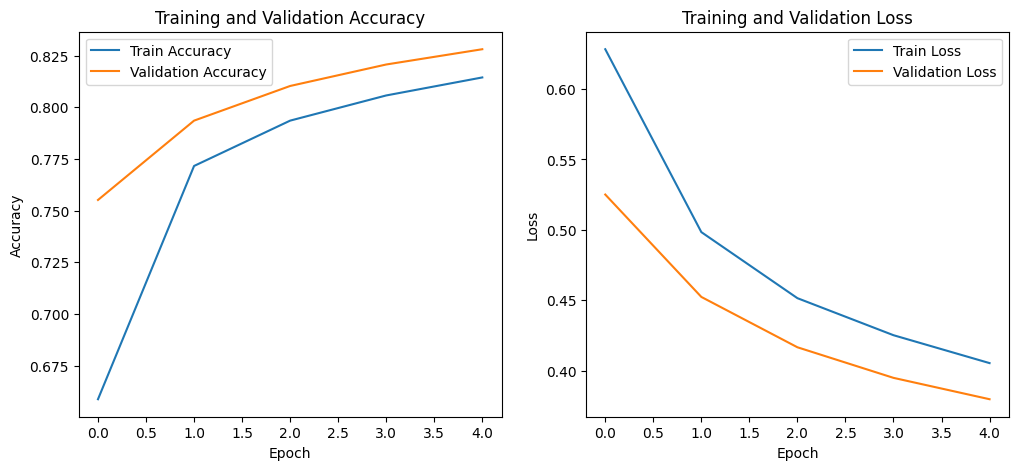

In [16]:
# 1. Function to Plot Training and Validation Loss and Accuracy
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    # Plot Training and Validation Accuracy over epochs
    plt.subplot(1, 2, 1) 
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy') 
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

**Plotting Training and Validation Metrics**:

The plot_metrics function visualizes how training and validation accuracy and loss change over epochs. This is crucial for diagnosing overfitting or underfitting by observing if the training and validation metrics diverge.

In [17]:
# 2. Evaluate the Model on Test Data and Generate Predictions
# Predict the probabilities for the test dataset
y_pred_probs = model.predict(tfdataset_test)
# Convert predicted probabilities to label indices by taking the class with the highest probability
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Set to '2' for warnings only, '3' to suppress info & warnings

W0000 00:00:1730336595.269392     194 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


2704/2706 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

W0000 00:00:1730336655.841135     194 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


2706/2706 ━━━━━━━━━━━━━━━━━━━━ 63s 22ms/step


In [18]:
# Get true labels from the test dataset for comparison
y_true = []
for _, labels in tfdataset_test.unbatch(): # Unbatch the dataset to access individual labels
    y_true.append(labels.numpy()) # Append each label to y_true list
    
# Convert the list of labels to a TensorFlow tensor and then to a NumPy array for compatibility with metrics functions
y_true = tf.convert_to_tensor(y_true).numpy()

**Evaluation and Prediction**:

Predictions are generated for the test dataset, and then the predicted class labels (y_pred) are compared to the true labels (y_true). This allows you to compute accuracy and other metrics.

In [19]:
# 3. Print Classification Report
# Generate a classification report to evaluate model performance on different metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83     10509
           1       0.87      0.78      0.82     11132

    accuracy                           0.83     21641
   macro avg       0.83      0.83      0.83     21641
weighted avg       0.83      0.83      0.83     21641



**Classification Report**:

The classification report gives detailed information on precision, recall, and F1-score for each class, as well as overall metrics. This is particularly useful for assessing performance on imbalanced datasets.

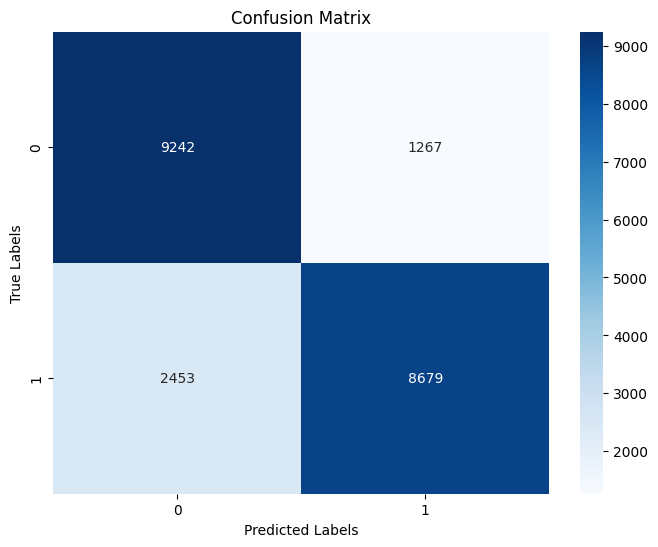

In [20]:
# 4. Plot Confusion Matrix
# Compute the confusion matrix based on true and predicted labels
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
# Plot the confusion matrix as a heatmap for visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Confusion Matrix**:

The confusion matrix provides a detailed breakdown of correct and incorrect predictions across classes, helping identify where the model may be misclassifying.

In [21]:
# 5. Save the Model and Additional Information
# Ensure the directory exists where the model and information will be saved
os.makedirs('./model', exist_ok=True)
# Save the trained Keras model in .keras format (or .h5)
model.save('./model/clf.keras') 
# Save additional information like model name and MAX_LEN using pickle
with open('./model/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)

**Saving Model and Additional Info**:

* The trained model is saved in the ./model directory with the extension .keras (or .h5). This allows for future reuse without retraining.
* Additional information, like MODEL_NAME and MAX_LEN, is saved in a separate file (info.pkl) for easier model reloading and configuration matching later.

# Explanation of Modifications

**1. SMOTE Integration for Data Imbalance**
* Change: I added the imblearn library and incorporated SMOTE to handle class imbalance.
* Why: SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples to balance the classes, improving model performance on imbalanced datasets.

**2. Custom Model Architecture with DistilBERT Base Model**
* Change: Instead of using TFDistilBertForSequenceClassification (which includes a pre-defined classification head), I initialized TFDistilBertModel directly to extract the base DistilBERT model. Then, I created a custom architecture by adding layers such as Dense, Dropout, and a Lambda layer to wrap the base model.
* Why: This customization provides greater flexibility to adjust the architecture, like increasing the dropout rate to prevent overfitting.

**3. Custom Classifier Layer and Adjusted from_logits Argument**
* Change: I modified the classifier layer to use softmax activation with from_logits=False in the loss function.
* Why: This change allows the model’s output to be a probability distribution directly. Setting from_logits=False ensures the loss function interprets the model’s outputs correctly as probabilities.

**4. Class Weights for Handling Imbalanced Data**
* Change: I calculated class_weights using compute_class_weight and incorporated them during model training with the class_weight parameter.
* Why: The class weights guide the model to focus more on minority classes, balancing the effect of class imbalance during training.

**5. Increased Epochs and Reduced Batch Size for Fine-Tuning**
* Change: I increased the number of epochs from 3 to 5 and reduced the batch size to 8.
* Why: These adjustments allow for longer training on smaller batches, which can improve learning on imbalanced or smaller datasets while stabilizing model convergence.

**6. Evaluation and Plotting Metrics**
* Change: I introduced functions to plot training metrics (accuracy and loss) and evaluate the model with confusion matrices and classification reports.
* Why: Visualizing the training and validation metrics, as well as evaluating predictions with classification reports and confusion matrices, helps assess the model’s performance and diagnose potential overfitting.

**7. Saving the Model Using .save Instead of save_pretrained**
* Change: I used the model.save('./model/clf.keras') format for saving the custom model, instead of save_pretrained, which was incompatible with the custom Keras model.
* Why: Custom Keras models can be saved with .h5 or .keras extensions, which are compatible with the Keras model API, allowing future loading without issues.

**8. Suppression of Warnings and Info Logs**
* Change: I set logging levels to suppress TensorFlow and Transformers warnings using logging.set_verbosity_error() and os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'.
* Why: These additions prevent log clutter, focusing output on essential information rather than repeated warning messages.


# Summary of the Impact
* **Enhanced Data Handling**: SMOTE and class weights are tailored to improve performance on imbalanced data.
* **Improved Model Flexibility and Fine-Tuning**: Custom architecture and dropout help with overfitting, while longer training with reduced batch size can stabilize learning.
* **Diagnostic and Usability Improvements**: Plotting, evaluation tools, and logging suppression enhance model interpretability and usability.